In [3]:
import imageio.v2 as iio
import imageio.v3 as iio3
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage import generic_filter
from pathlib import Path
import pickle
from tqdm import tqdm

In [4]:
video_path = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/original_videos")
binary_path = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/binary_frames")
subsampled_path = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/subsampled_frames")
latents_path = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/latents")
pickle_path = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/pickle_files/shortened_real_finger_pos_time_1.5_ls_0.6_mean_22_var_4_scale_100.pkl")
pickle_path.parent.mkdir(parents=True, exist_ok=True)

In [44]:
def save_binary_video(original_video, binary_frames):
    fps = iio.get_reader(original_video, format="ffmpeg").get_meta_data()["fps"]
    out_video = binary_videos/f"{original_video.stem}.mp4"
    iio.mimsave(out_video, binary_frames, fps=fps)

In [47]:
def convert_to_binary(video):
    binary_frames = []
    for idx, frame in enumerate(iio3.imiter(video)):
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        gray_value = cv2.GaussianBlur(gray, (11,11), 0)            
        T, bw = cv2.threshold(gray_value, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # flip = cv2.bitwise_not(bw)
        binary_frames.append(bw.astype(np.uint8))
    return binary_frames

In [48]:
for video in tqdm(list(video_path.glob("*.avi"))):
    print("Converting:", video.name)
    binary_frames = convert_to_binary(video)
    out_path = binary_path/f"{video.stem}.npy"
    np.save(out_path, np.stack(binary_frames))

Converting: video_15.avi
Converting: video_87.avi
Converting: video_53.avi
Converting: video_83.avi
Converting: video_98.avi
Converting: video_58.avi
Converting: video_79.avi
Converting: video_46.avi
Converting: video_54.avi
Converting: video_93.avi
Converting: video_17.avi
Converting: video_30.avi
Converting: video_32.avi
Converting: video_94.avi
Converting: video_38.avi
Converting: video_11.avi
Converting: video_88.avi
Converting: video_29.avi
Converting: video_74.avi
Converting: video_19.avi
Converting: video_86.avi
Converting: video_13.avi
Converting: video_21.avi
Converting: video_27.avi
Converting: video_52.avi
Converting: video_22.avi
Converting: video_26.avi
Converting: video_49.avi
Converting: video_1.avi
Converting: video_84.avi
Converting: video_42.avi
Converting: video_41.avi
Converting: video_73.avi
Converting: video_80.avi
Converting: video_62.avi
Converting: video_14.avi
Converting: video_64.avi
Converting: video_61.avi
Converting: video_66.avi
Converting: video_2.avi
Co

In [3]:
def subsample(frames, subsample_size):
    total_frames = len(frames)
    subsample_idx = np.linspace(0, total_frames-1, subsample_size).astype(int)
    return frames[subsample_idx]

In [92]:
def resize(binary_arr, scale=0.06):
    resized = []
    for frame in binary_arr:
        img = Image.fromarray(frame, mode='L')
        w, h = img.size
        img = img.resize((int(w * scale), int(h * scale)), Image.NEAREST)
        resized.append(np.array(img))
    return np.array(resized)

In [49]:
sum_frames = 0
for path in tqdm(list(binary_path.glob("*.npy"))):
    frame = np.load(path)
    sum_frames += (frame).astype(np.int32)
# plt.imshow(sum_frames)

100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


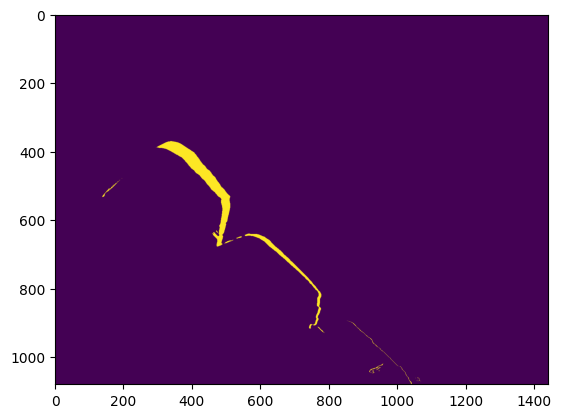

In [103]:
plt.imshow(sum_frames[97] - sum_frames[0] > 0 )

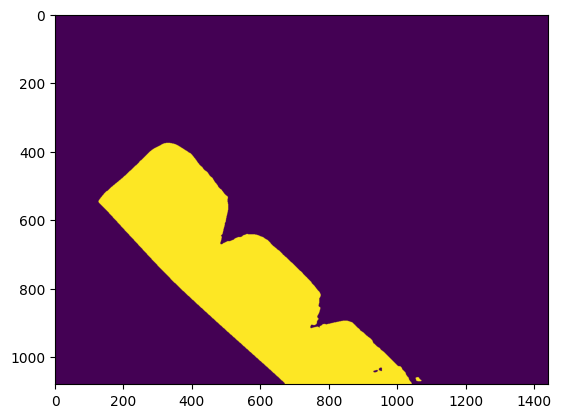

In [89]:
plt.imshow(sum_frames[80]>0)

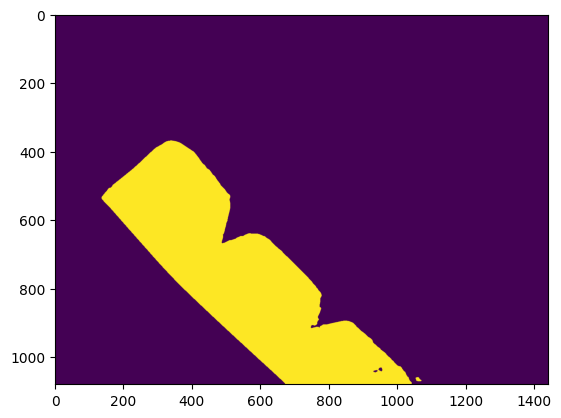

In [67]:
plt.imshow(sum_frames[100]>0)

In [93]:
# subsample_size = 600
for path in tqdm(list(binary_path.glob("*.npy"))):
    frames = np.load(path)
    shortened_frames = frames[80:]
    resized_frames = resize(shortened_frames)
    out_path = subsampled_path/path.name
    np.save(out_path, resized_frames)

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.69it/s]


In [106]:
frame_files = sorted(subsampled_path.glob("*.npy"))
latent_files = sorted(latents_path.glob("*.npy"))
frames = []
latents = []
for frame, latent in zip(frame_files, latent_files):
    frames.append(np.load(frame))
    latents.append(np.load(latent))

In [125]:
1.5 / 291

0.005154639175257732

In [126]:
291 - 80

211

In [127]:
291 - 194

97

In [128]:
time = 1.0876288659793814
num_frames = frames[0].shape[0]

In [132]:
211 / time

194.00000000000003

In [110]:
import torch

In [109]:
with open(pickle_path, "wb") as f:
    pickle.dump(
        dict(
            frames = np.stack(frames),
            latents = np.stack(latents),
            dt = time / num_frames,
            subsample = 1000,
            time = time,
            height = frames[0].shape[1],
            width = frames[0].shape[2]
        ), f
    )

In [28]:
# def save_npy_video(npy_path, out_path, fps=20):
#     frames = np.load(npy_path)
#     if frames.dtype != np.uint8:
#         frames = (frames * 255).clip(0, 255).astype(np.uint8)
#     if len(frames.shape) == 3:  # (num_frames, H, W)
#         frames = np.expand_dims(frames, -1)
#     if frames.shape[-1] == 1:
#         frames = np.repeat(frames, 3, axis=-1)
#     iio.mimsave(out_path, frames, fps=fps)
#     # print(f"Saved video to: {out_path}")

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

def save_npy_gif_single(
    npy_path,
    save_path="ground_truth.gif",
    fps=20,
    cmap="gray",
    title="Ground Truth",
    dpi=120,
    pad_inches=0.02,
    times=None,
):
    frames = np.load(npy_path)

    # Ensure correct numeric format
    if frames.dtype != np.uint8:
        frames = (frames * 255).clip(0, 255).astype(np.uint8)

    # If grayscale, expand to RGB for GIF
    if len(frames.shape) == 3:  # (T, H, W)
        frames = np.expand_dims(frames, -1)
    if frames.shape[-1] == 1:
        frames = np.repeat(frames, 3, axis=-1)

    vmin, vmax = float(frames.min()), float(frames.max())
    T = frames.shape[0]
    images = []

    for t in range(T):
        fig, ax = plt.subplots(figsize=(4, 3), dpi=dpi)
        ax.imshow(frames[t], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.axis("off")
        # ax.set_title(title, fontsize=10)
        # ax.set_xticks([]); ax.set_yticks([])

        # if times is not None and t < len(times):
            # fig.suptitle(f"t = {times[t]:.3f} s", fontsize=9, y=0.98)

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)[..., :3]
        images.append(frame)
        plt.close(fig)

    imageio.mimsave(save_path, images, fps=fps, loop=0)
    print(f"GIF saved to {save_path}")


# --- Example usage ---
frames = np.load(npy_file)            # load once to get number of frames
fps = 194
T = frames.shape[0]
times_s = np.arange(T) / fps

save_npy_gif_single(npy_file, "ground_truth.gif", fps=fps, times=times_s)

GIF saved to ground_truth.gif


In [17]:
def save_npy_frames(npy_path, out_dir):
    frames = np.load(npy_path)
    print(len(frames))
    if frames.dtype != np.uint8:
        frames = (frames * 255).clip(0, 255).astype(np.uint8)
    if frames.ndim == 3:   
        pass
    elif frames.ndim == 2: 
        frames = frames[None, :, :]
    else:
        raise ValueError(f"Unexpected shape {frames.shape}")
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    for i, frame in enumerate(frames):
        if frame.ndim == 2:
            frame = np.repeat(frame[:, :, None], 3, axis=-1)
        fname = out_dir / f"frame_{i:04d}.png"
        iio.imwrite(fname, frame)
    # print(f"Saved {len(frames)} frames to {out_dir}")

In [25]:
npy_file = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/binary_frames/video_0.npy")
out_video = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/video_2_test.mp4")
out_dir  = "/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/video_9_frames"
save_npy_video(npy_file, out_video, fps=400)
save_npy_frames(npy_file, out_dir)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1440, 1080) to (1440, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x1ebf6080] Stream #0: not enough frames to estimate rate; consider increasing probesize


291



KeyboardInterrupt



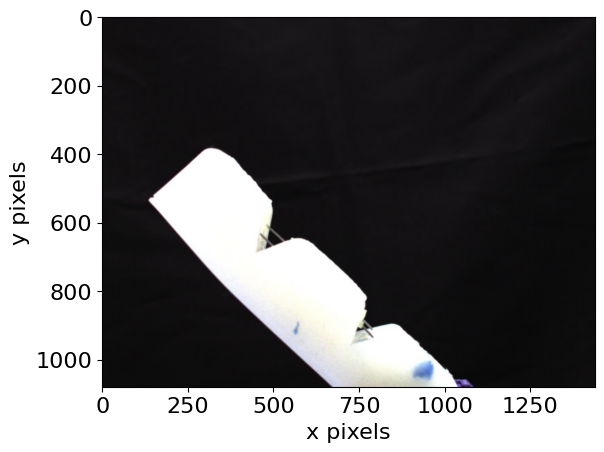

In [11]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

video_path = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/original_videos/video_0.avi")

cap = cv2.VideoCapture(str(video_path))

ret, frame = cap.read()   # Read first frame
cap.release()

if ret:
    # Convert BGR (OpenCV default) → RGB (matplotlib expects RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.xlabel("x pixels", fontsize=16)
    plt.ylabel("y pixels", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

In [13]:
import cv2
import imageio
from pathlib import Path

video_path = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/original_videos/video_0.avi")
gif_path = video_path.with_suffix(".gif")

cap = cv2.VideoCapture(str(video_path))
frames = []

# Get original FPS (frames per second)
fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0:
    fps = 25  # fallback default

# Duration per frame in seconds
frame_duration = 1.0 / fps

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

cap.release()

# Write GIF at original frame rate
imageio.mimsave(gif_path, frames, duration=frame_duration)

print(f"GIF saved to {gif_path} at {fps:.2f} FPS")


GIF saved to /home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/original_videos/video_0.gif at 194.00 FPS


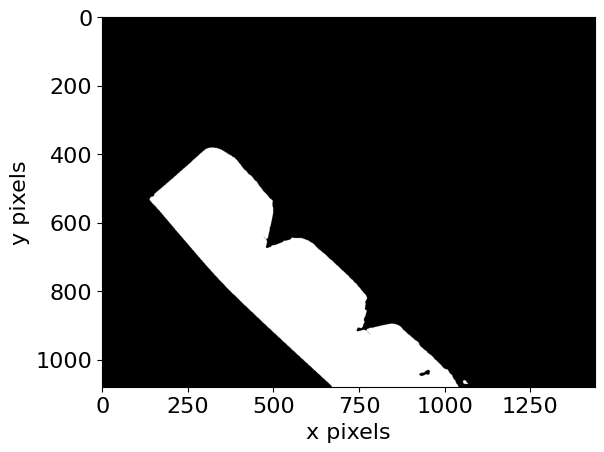

In [18]:
npy_file = Path("/home/kendra/Code/Learning-Dynamics-Latent-Force/data/ODEs/finger/real_finger/binary_frames/video_9.npy")
frames = np.load(npy_file)
plt.xlabel("x pixels", fontsize=16)
plt.ylabel("y pixels", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.imshow(frames[0], cmap="gray")

In [46]:
frames.shape

(211, 64, 86)

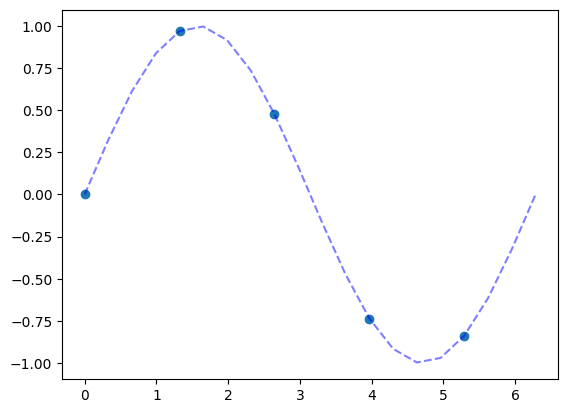

In [112]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi, 20)  
y = np.sin(x)  

# Take every 4th point for both x and y
xhat = x[::4]
yhat = y[::4]

# Scatter only a few points
plt.scatter(xhat, yhat, marker="o")

# Dashed line through all original points
plt.plot(x, y, linestyle="--", color="blue", alpha=0.5)
plt.show()

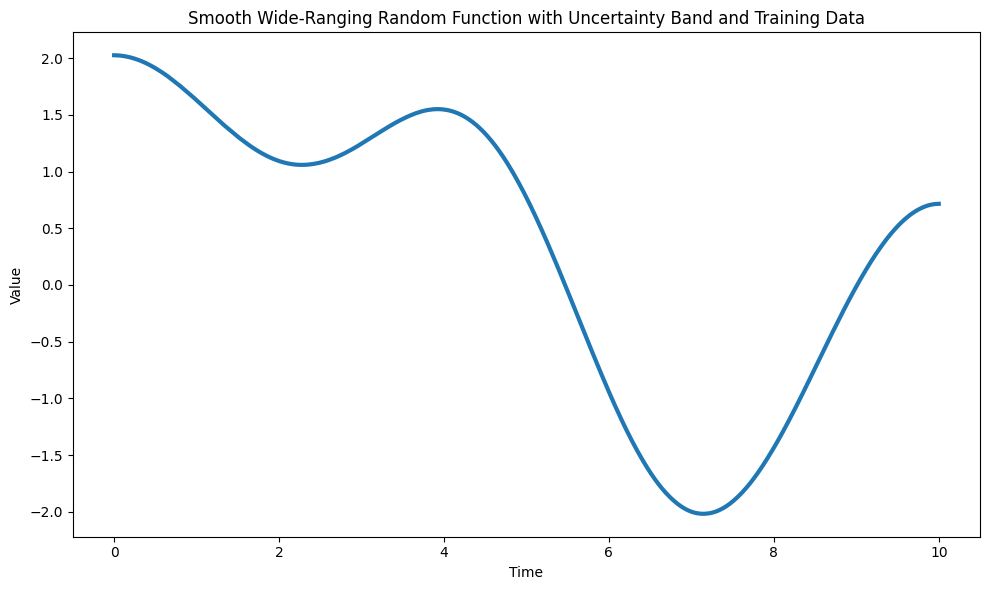

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Reproducibility
# rng = np.random.default_rng(123)

# Time axis
t = np.linspace(0, 10, 600)

# Generate a very smooth, large-scale random mean function
raw = rng.standard_normal(len(t))
mu = gaussian_filter1d(raw, sigma=100)
mu = (mu - mu.min()) / (mu.max() - mu.min()) * 4 - 2  # normalize to [-2, 2] → fills space more

# Smooth, low-frequency uncertainty
sigma = 0.4 + 0.2 * gaussian_filter1d(rng.random(len(t)), sigma=100)

# Smooth random noise generator for realizations
def smooth_noise(n, sigma=60):
    return gaussian_filter1d(rng.standard_normal(n), sigma=sigma)

# Generate several smooth realizations with moderate variability
n_realizations = 1
Ys = [mu + sigma * smooth_noise(len(t), sigma=60) for _ in range(n_realizations)]

# Generate training data (noisy samples)
n_train = 25
t_train = np.sort(rng.choice(t, size=n_train, replace=False))
y_train = np.interp(t_train, t, mu) + rng.normal(scale=0.15, size=n_train)

# Plot
plt.figure(figsize=(10,6))

# Uncertainty band
# plt.fill_between(t, mu - sigma, mu + sigma, color='lightsteelblue', alpha=0.3, label="Uncertainty band (μ ± σ)")

# Mean
# plt.plot(t, mu, color='black', linewidth=2.5, label="Mean μ(t)")

# Realizations
for i, y in enumerate(Ys, 1):
    plt.plot(t, y, linewidth=3, alpha=1.0, label=f"Realization {i}")

# Training data
# plt.scatter(t_train, y_train, color='blue', marker='x', s=60, label="Training data")

plt.title("Smooth Wide-Ranging Random Function with Uncertainty Band and Training Data")
plt.xlabel("Time")
plt.ylabel("Value")
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


In [118]:
# frame ossicilations video 9
# 152-167-180-193-204-214
gaps = np.array([15, 13, 13, 11, 10])
fps = 194.0
seconds = gaps/194
avg_period = sum(seconds)/len(seconds)
freq = 1/avg_period # hz
ang_freq = freq * 2 * np.pi # rad/s

In [35]:
ang_freq

98.30144754780966

In [36]:
# frame ossicilations video 7
# 142-156-172-183
gaps = np.array([14, 16, 11])
fps = 194.0
seconds = gaps/194
avg_period = sum(seconds)/len(seconds)
freq = 1/avg_period # hz
ang_freq = freq * 2 * np.pi # rad/s

In [37]:
ang_freq

89.19058167752486

In [5]:
!pip show imageio

Name: imageio
Version: 2.37.0
Summary: Library for reading and writing a wide range of image, video, scientific, and volumetric data formats.
Home-page: https://github.com/imageio/imageio
Author: imageio contributors
Author-email: almar.klein@gmail.com
License: BSD-2-Clause
Location: /home/kendra/miniconda3/lib/python3.12/site-packages
Requires: numpy, pillow
Required-by: scikit-image


In [10]:
iio.mimsave

<function imageio.v2.mimwrite(uri, ims, format=None, **kwargs)>